In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv

from GraphDataset import MyDataset
from torch_geometric.loader import DataLoader


In [2]:
# Load soft labels with membership level to each cover

df_data = pd.read_csv('data/ReyZamuro_softLabels.csv',index_col=0)
df_data = df_data.drop('RZUB02')
df_data = df_data.drop('RZUA03b')
print(df_data.head())

                   1         2         3
field_numb                              
RZUA01      1.000000  0.000000  0.000000
RZUA02      1.000000  0.000000  0.000000
RZUA04      0.589278  0.410722  0.000000
RZUA05      0.892664  0.000000  0.107336
RZUA06      0.938423  0.000000  0.061577


In [3]:
#Create list of ARUs and labels

DatosN = list(df_data.index)
Clases = df_data.values.argmax(1)
etiquetasN = Clases

In [4]:
features = 'AI'#'PANNs'#'YAMNet' #'VGGish'#'AI'

train_dataset = MyDataset(ListaArchivos=DatosN,
                          etiquetas=etiquetasN, caract=features)
print(len(train_dataset))

92


In [5]:
unpacked_data = [train_dataset[i][0] for i in range(len(train_dataset))]
x = torch.stack(unpacked_data, dim=0).transpose(0,1)

0
RZUA01
file_path='/media/andrescastro/Seagate Backup Plus Drive/AECO/AcousticIndices_data/ReyZamuro/RZUA01_AIs.csv'
n_feat=60
10
                                                                  file
Date                                                                  
2022-09-05 10:00:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:15:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:30:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 10:45:00  /media/andrescastro/Seagate Backup Plus Drive/...
11
                                                                  file
Date                                                                  
2022-09-05 11:00:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:15:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:30:00  /media/andrescastro/Seagate Backup Plus Drive/...
2022-09-05 11:45:00  /media/andrescastro/Seagate Backup Plus Drive/...
12
           

In [6]:
x.shape

torch.Size([3, 92, 24, 60])

## Edge Creation

In [7]:
from utils import edge_creation_nodeinfo, is_connected, edge_creation_geoDistance, plot_distance_matrix_heatmap, edge_creation_coverinfo
from torch_geometric.utils import is_undirected

In [8]:
graphs = edge_creation_coverinfo(torch.tensor(df_data.values), x,'knn', k_neigh=11)
for i in graphs:
    print(f"Is the graph {i} connected? {is_connected(i)}")
    print(f'Is the graph undirected {is_undirected(i.edge_index)}')

Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True
Is the graph Data(x=[92, 24, 60], edge_index=[2, 1260]) connected? True
Is the graph undirected True


In [9]:
train_loader = DataLoader(graphs, batch_size=1, shuffle=False)

## Crear modelo y entrenar

In [ ]:
class MatrixGCNVAE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, latent_dim, num_nodes, heads=1):
        super(MatrixGCNVAE, self).__init__()
        
        # Encoder components
        self.conv1d = torch.nn.Conv1d(1, 64, 24, stride=24)
        self.gat1 = GATv2Conv(in_channels, hidden_channels, heads=heads)
        
        # Mean and log variance layers for the latent distribution
        self.bn = torch.nn.BatchNorm1d(hidden_channels)
        self.fc_mu = GATv2Conv(hidden_channels*heads, latent_dim, heads=1)
        self.fc_logvar = GATv2Conv(hidden_channels*heads, latent_dim, heads=1)
        
        # Decoder components for node features
        self.decoder_fc1 = torch.nn.Linear(latent_dim, hidden_channels)
        self.num_rec = int(in_channels*24/64)
        self.decoder_fc2 = torch.nn.Linear(hidden_channels, self.num_rec)
        
        # Decoder components for adjacency matrix
        self.num_nodes = num_nodes
        self.adj_decoder = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, hidden_channels),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_channels, num_nodes)
        )
        
    def encode(self, x, edge_index):
        # Process input features
        x = x.transpose(1, 2).flatten(1)  # Flatten the matrix features
        x = self.conv1d(x.unsqueeze(1))
        x = x.view(x.size(0), -1)
        
        # GCN encoding
        x = self.gat1(x, edge_index)
        x = F.relu(x)
        
        # Get latent distribution parameters
        x = self.bn(x)
        mu = self.fc_mu(x, edge_index)
        logvar = self.fc_logvar(x, edge_index)
        
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        return mu + torch.randn_like(logvar) * torch.exp(logvar)
    
    def decode(self, z):
        # Decode node features from latent space
        h = F.relu(self.decoder_fc1(z))
        node_reconstruction = self.decoder_fc2(h)
        
        # Decode adjacency matrix from latent space
        adj_logits = self.adj_decoder(z)
        # Create adjacency predictions - a matrix where each row i contains scores for edges from node i to all nodes
        adj_matrix = torch.sigmoid(torch.matmul(adj_logits, adj_logits.transpose(0, 1)))
        
        return node_reconstruction, adj_matrix
    
    def forward(self, x, edge_index):
        # Encode to get latent distribution
        mu, logvar = self.encode(x, edge_index)
        # mu, logvar = torch.tanh(mu), torch.tanh(logvar)
        # Sample from the latent distribution
        z = self.reparameterize(mu, logvar)
        # print(z)
        # Decode to get reconstructions
        node_reconstruction, adj_reconstruction = self.decode(z)
        
        return node_reconstruction, adj_reconstruction, mu, logvar
    
    def edge_index_to_adj_matrix(self, edge_index, num_nodes):
        """Convert edge_index to dense adjacency matrix"""
        adj_matrix = torch.zeros((num_nodes, num_nodes), device=edge_index.device)
        adj_matrix[edge_index[0], edge_index[1]] = 1.0
        return adj_matrix
    
    def loss_function(self, node_reconstruction, adj_reconstruction, x_original, edge_index, mu, logvar, alpha=1.0, beta=1.0):
        # Node feature reconstruction loss (MSE)
        # print(f"true reconstructed= {node_reconstruction.shape}, original={x_original.transpose(1, 2).flatten(1).shape}")
        feature_loss = F.mse_loss(node_reconstruction, x_original.transpose(1, 2).flatten(1))
        
        # Adjacency matrix reconstruction loss (BCE)
        true_adj = self.edge_index_to_adj_matrix(edge_index, self.num_nodes)
        
        # Binary cross entropy for adjacency matrix
        # We can add class weights if the graph is sparse
        # print(f"{adj_reconstruction.double()=}")
        # print(f"{true_adj.double()=}")
        adj_loss = F.binary_cross_entropy(adj_reconstruction.double(), true_adj.double())
        
        # KL Divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        
        # Total loss with weighting factors
        total_loss = feature_loss + alpha * adj_loss + beta * kl_loss
        
        return total_loss, feature_loss, adj_loss, kl_loss

In [11]:
max_nodes = max([data.num_nodes for data in graphs])
num_feat = graphs[0].x.shape[-1]
num_feat

60

In [12]:
model = MatrixGCNVAE(in_channels=64*num_feat, hidden_channels=num_feat, latent_dim=64, num_nodes=max_nodes)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) #0.01 GCN

# Training function
def train():
    model.train()
    model.double()
    for graph in train_loader:
        optimizer.zero_grad()
        node_reconstruction, adj_reconstruction, mu, logvar = model(graph.x.double(), graph.edge_index)
        loss, feature_loss, adj_loss, kl_loss = model.loss_function(node_reconstruction, adj_reconstruction, graph.x.double(),graph.edge_index, mu, logvar, alpha=1.0, beta=1.0)
        loss.backward()
        optimizer.step()
    return loss.item()

# Train the model
for epoch in range(1, 1001):
    loss = train()
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 100, Loss: 9803199.8163
Epoch: 200, Loss: 3532362.3524
Epoch: 300, Loss: 3134813.3993
Epoch: 400, Loss: 2926814.2898
Epoch: 500, Loss: 2797901.7592
Epoch: 600, Loss: 2675952.1246
Epoch: 700, Loss: 2620891.5819
Epoch: 800, Loss: 2574993.5080
Epoch: 900, Loss: 2533546.7699
Epoch: 1000, Loss: 2481801.8950


In [13]:
# Generate embeddings
model.eval()
with torch.no_grad():
    for graph in train_loader:
        _, _, mu, logvar = model(graph.x.double(), graph.edge_index)
        embeddings = model.reparameterize(mu, logvar)

In [14]:
print(embeddings.shape)
embeddings = (embeddings - embeddings.min(0).values)/(embeddings.max(0).values - embeddings.min(0).values)

torch.Size([92, 64])


In [15]:
df_map = pd.read_csv('./data/ReyZamuro_latlon.csv',index_col='field_numb')
df_map = df_map.drop('RZUA03b')

## Matriz de similitud

In [16]:
embs = embeddings.numpy()
sim_mat = (embs@embs.T)
sim_mat

array([[15.37972372, 15.08651389, 13.54218485, ..., 13.3501735 ,
        12.86126433, 13.43320881],
       [15.08651389, 15.98684553, 15.08330349, ..., 15.53867465,
        14.87599746, 14.68091297],
       [13.54218485, 15.08330349, 20.9462831 , ..., 20.42302989,
        20.50607171, 17.03077668],
       ...,
       [13.3501735 , 15.53867465, 20.42302989, ..., 22.10449178,
        21.58994812, 17.86739839],
       [12.86126433, 14.87599746, 20.50607171, ..., 21.58994812,
        22.42607298, 17.63918141],
       [13.43320881, 14.68091297, 17.03077668, ..., 17.86739839,
        17.63918141, 16.11869698]])

In [17]:
# norms = np.linalg.norm(embs, axis=1)
# sim_mat = embs @ embs.T / (norms[:, np.newaxis] @ norms[np.newaxis, :])
# sim_mat

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from utils import edge_index_to_adjacency

In [19]:
adj_graph = edge_index_to_adjacency(graph.edge_index)

In [20]:
np.triu(sim_mat, k=-1)

array([[15.37972372, 15.08651389, 13.54218485, ..., 13.3501735 ,
        12.86126433, 13.43320881],
       [15.08651389, 15.98684553, 15.08330349, ..., 15.53867465,
        14.87599746, 14.68091297],
       [ 0.        , 15.08330349, 20.9462831 , ..., 20.42302989,
        20.50607171, 17.03077668],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 22.10449178,
        21.58994812, 17.86739839],
       [ 0.        ,  0.        ,  0.        , ..., 21.58994812,
        22.42607298, 17.63918141],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        17.63918141, 16.11869698]])

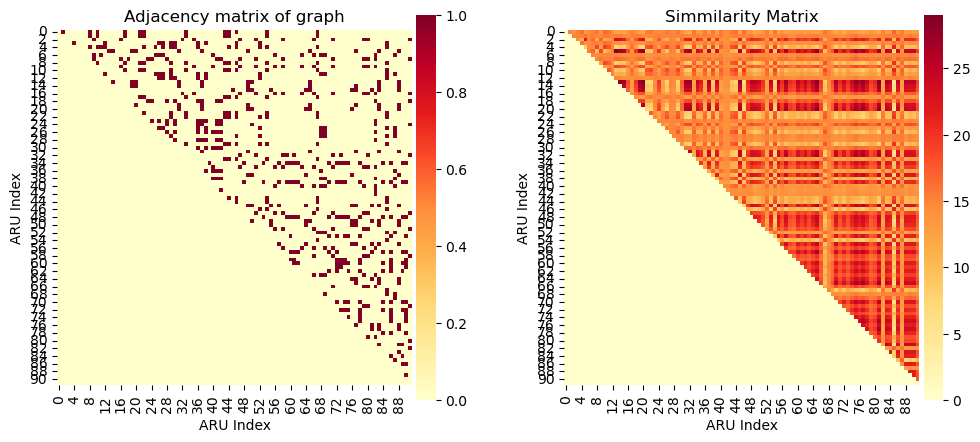

In [21]:
plt.figure(figsize=(12, 10))
plt.subplot(121)
sns.heatmap(np.triu(adj_graph, k=1), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Adjacency matrix of graph')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")
plt.subplot(122)
sns.heatmap(np.triu(sim_mat, k=1), cmap="YlOrRd", square=True, cbar_kws=dict(use_gridspec=False,location="right",pad=0.01,shrink=0.5))
plt.title('Simmilarity Matrix')
plt.xlabel("ARU Index")
plt.ylabel("ARU Index")

plt.show()

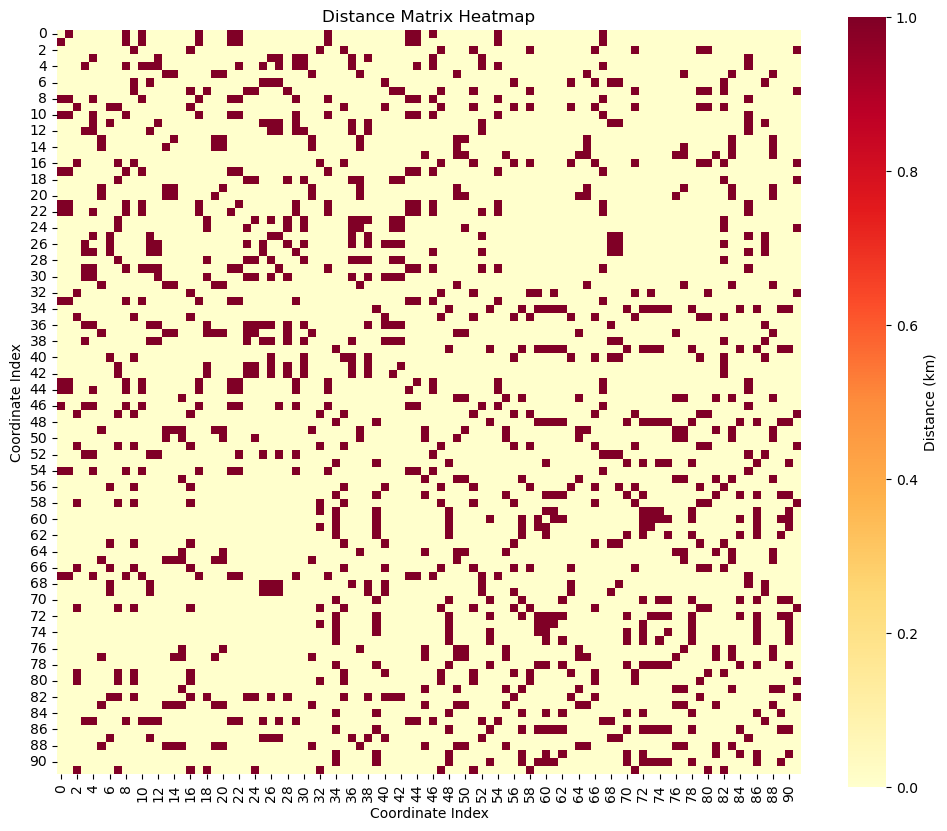

In [22]:
plot_distance_matrix_heatmap(adj_graph)

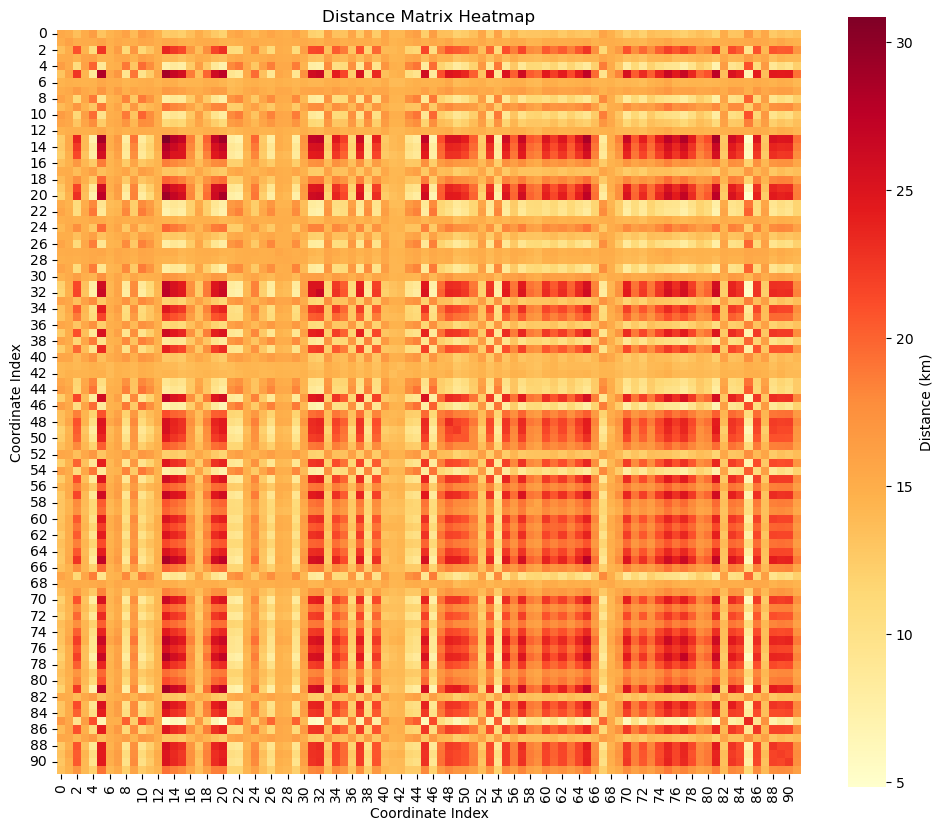

In [23]:
plot_distance_matrix_heatmap(sim_mat)

In [24]:
# density metric:

print(np.mean(sim_mat)) #axis = 0: por nodos

15.892297940963834


In [25]:
# connectivity metric (only if thresholded):

print(np.count_nonzero(sim_mat))

8464


In [26]:
# total weight (es density sin promediar)

print(np.sum(sim_mat))

134512.4097723179


In [27]:
def floyd_warshall(matrix):
    """Implement Floyd-Warshall algorithm for all-pairs shortest paths"""
    n = len(matrix)
    dist = np.array(matrix, dtype=float)
    
    # Replace inf with large number for calculations
    dist[dist == float('inf')] = 1e9
    
    for k in range(n):
        for i in range(n):
            for j in range(n):
                dist[i][j] = min(dist[i][j], dist[i][k] + dist[k][j])
    
    return dist

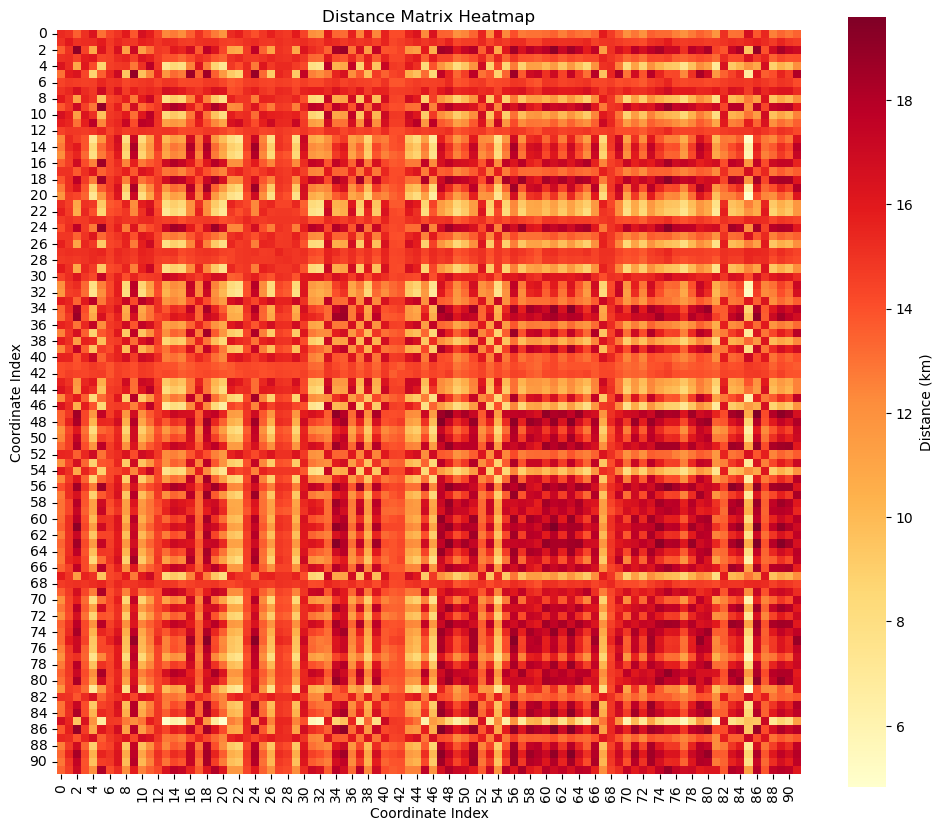

In [28]:
dist_matrix = floyd_warshall(sim_mat)
plot_distance_matrix_heatmap(dist_matrix)

In [29]:
# diameter
print(np.max(dist_matrix))

19.592879998249938


In [30]:
#average path
print(np.mean(dist_matrix))

14.215119914721027


In [31]:
#Betweeness centrality

n = len(dist_matrix)
centrality = np.zeros(n)
for s in range(n):
    for t in range(n):
        if s != t:
            # Count shortest paths going through each vertex
            for v in range(n):
                if v != s and v != t:
                    if dist_matrix[s][t] == dist_matrix[s][v] + dist_matrix[v][t]:
                        centrality[v] += 1
value = np.mean(centrality)
print(value)

24.869565217391305
